In [1]:
push!(LOAD_PATH, "../code")

3-element Array{Any,1}:
 "/Users/farr/Documents/code/julia/usr/local/share/julia/site/v0.6"
 "/Users/farr/Documents/code/julia/usr/share/julia/site/v0.6"      
 "../code"                                                         

In [3]:
using Aldebaran
using CARMAKepler
using Optim
using Periodogram
using PyCall
using PyPlot

@pyimport seaborn as sns
sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("colorblind")

In [4]:
ts, ys, dys = Aldebaran.load_timeseries();

In [5]:
tmin = minimum([minimum(t) for t in ts])
tmax = maximum([maximum(t) for t in ts])
T = tmax - tmin
muHz = 1e-6*(3600.0*24.0);

In [41]:
function trapz(ys, xs)
    0.5*(ys[2:end] .+ ys[1:end-1])'*diff(xs)
end

trapz (generic function with 1 method)

In [42]:
fs = exp.(collect(linspace(log(1e-3), log(5*muHz), 10000)))
coeffs = [Periodogram.pgram(ts, ys, dys, f) for f in fs]
rms_amps = [sqrt(c[end]^2 + c[end-1]^2) for c in coeffs]

10000-element Array{Float64,1}:
 117.98   
 118.143  
 118.299  
 118.447  
 118.587  
 118.718  
 118.842  
 118.956  
 119.061  
 119.156  
 119.242  
 119.318  
 119.384  
   ⋮      
   4.71246
   9.7391 
  10.712  
   9.34731
   1.24654
   7.47147
   8.33691
   8.43562
   8.93259
   4.63718
   3.00013
   6.91814

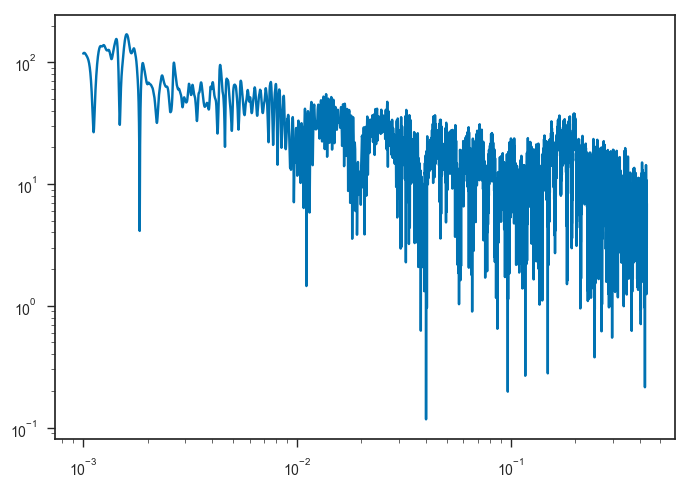

In [7]:
plot(fs, rms_amps)
xscale("log")
yscale("log")

In [8]:
Pkep = 1.0/fs[indmax(rms_amps)]

626.6823397842544

In [9]:
fs_zoom = collect(linspace(1*muHz, 5*muHz, 10000))
coeffs_zoom = [Periodogram.pgram(ts, ys, dys, f) for f in fs_zoom]
rms_amps_zoom = [sqrt(c[end]^2 + c[end-1]^2) for c in coeffs_zoom];

In [10]:
fs_peaks = fs_zoom[rms_amps_zoom .> 25]
freqs = []
f = []
for i in 1:size(fs_peaks, 1)-1
    push!(f, fs_peaks[i])
    if fs_peaks[i+1] - fs_peaks[i] > 2e-3
        push!(freqs, f)
        f = []
    end
end
freqs = [mean(f) for f in freqs]

8-element Array{Float64,1}:
 0.143637
 0.155084
 0.167164
 0.177663
 0.187701
 0.197862
 0.207303
 0.214924

In [11]:
diff(freqs)

7-element Array{Float64,1}:
 0.0114465 
 0.0120808 
 0.0104984 
 0.0100386 
 0.0101607 
 0.00944091
 0.00762124

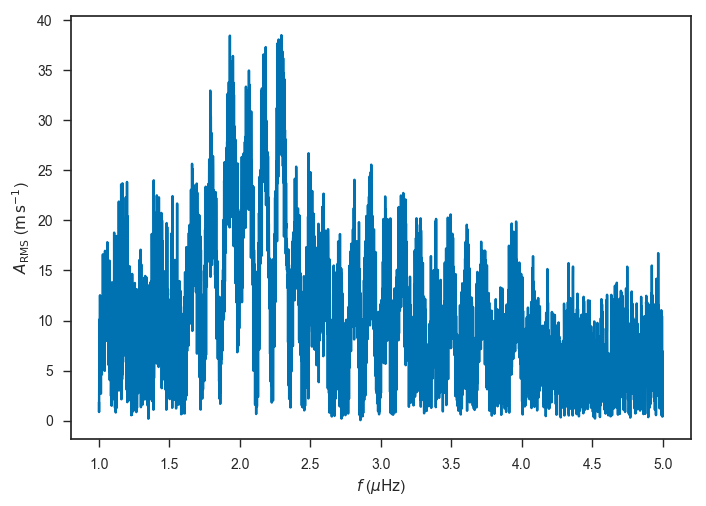

PyObject <matplotlib.text.Text object at 0x1555c4f28>

In [59]:
plot(fs_zoom/muHz, rms_amps_zoom)
xlabel(L"$f$ ($\mu \mathrm{Hz}$)")
ylabel(L"$A_\mathrm{RMS}$ ($\mathrm{m} \, \mathrm{s^{-1}}$)")

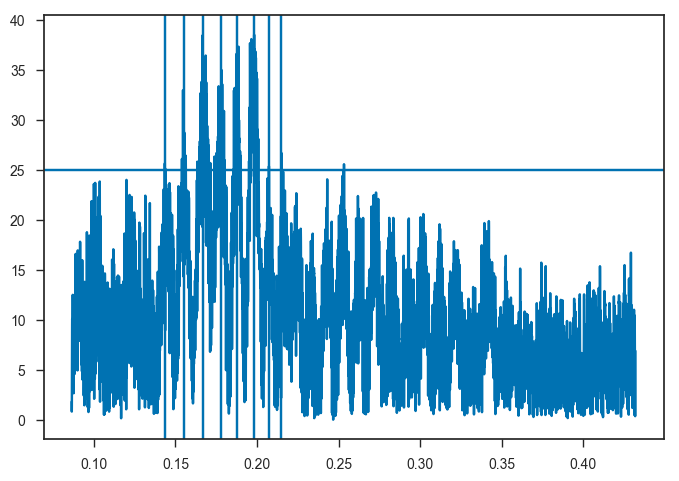

In [12]:
plot(fs_zoom, rms_amps_zoom)
axhline(25)
for f in freqs
    axvline(f)
end

In [29]:
post = CARMAKepler.MultiEpochPosterior(ts, ys, dys, 600.0, 700.0, 1, 8, 0.1*muHz, 5*muHz);
p0 = CARMAKepler.to_params(post, zeros(CARMAKepler.nparams(post)))

CARMAKepler.MultiEpochParams([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [5.05, 5.05, 5.05, 5.05, 5.05, 5.05, 5.05, 5.05], 899.9957168654438, 650.0, 0.5, 3.141592653589793, 0.5, [899.996], [12899.1], [899.996, 899.996, 899.996, 899.996, 899.996, 899.996, 899.996, 899.996], [0.22032, 0.32616, 0.37908, 0.40554, 0.41877, 0.425385, 0.428692, 0.430346], [28627.0, 28627.0, 28627.0, 28627.0, 28627.0, 28627.0, 28627.0, 28627.0])

In [53]:
p0.mu = [mean(y) for y in ys]
p0.nu = ones(size(ts, 1))
p0.K = rms_amps[indmax(rms_amps)]/10.0
p0.P = Pkep
p0.e = 0.1
p0.omega = 0.1
p0.chi = 0.2

p0.drw_rms = [1.0]
p0.drw_rate = [2e-2]

p0.osc_rms = 1.0*ones(8)
p0.osc_freq = sort(freqs)
p0.osc_Q = 100.0*ones(8);

In [54]:
x0 = CARMAKepler.to_array(post, p0)

47-element Array{Float64,1}:
  17.6103 
  -2.30259
  10.1944 
  -2.30259
 -33.404  
  -2.30259
  -7.28889
  -2.30259
  13.2552 
  -2.30259
  13.9524 
  -2.30259
  20.5357 
   ⋮      
  -8.71354
  -3.19195
  -6.34933
  -8.71354
  -3.13738
  -6.34933
  -8.71354
  -3.1697 
  -6.34933
  -8.71354
  -3.34931
  -6.34933

In [56]:
function log_posterior(x)
    lp = CARMAKepler.log_prior(post, x)
    if lp == -Inf
        lp
    else
        lp + CARMAKepler.log_likelihood(post, x)
    end
end

log_posterior (generic function with 1 method)

In [57]:
optim_result = Optim.optimize(x -> -log_posterior(x), x0, BFGS())

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] log(::Array{Float64,1}) at ./deprecated.jl:57
 [3] log_prior(::CARMAKepler.MultiEpochPosterior, ::CARMAKepler.MultiEpochParams) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:192
 [4] log_prior(::CARMAKepler.MultiEpochPosterior, ::Array{Float64,1}) at /Users/farr/Documents/Research/Aldebaran/code/CARMAKepler.jl:175
 [5] log_posterior at ./In[56]:2 [inlined]
 [6] (::##21#22)(::Array{Float64,1}) at ./In[57]:1
 [7] finite_difference!(::##21#22, ::Array{Float64,1}, ::Array{Float64,1}, ::Symbol) at /Users/farr/.julia/v0.6/Calculus/src/finite_difference.jl:126
 [8] (::Optim.#g!#5{##21#22})(::Array{Float64,1}, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/Optim/src/objective_types.jl:54
 [9] #OnceDifferentiable#2(::Symbol, ::Type{T} where T, ::##21#22, ::Array{Float64,1}) at /Users/farr/.julia/v0.6/Optim/src/objective_types.jl:83
 [10] optimize at /Users/farr/.julia/v0.6/Optim/src/multivariate/optimize/i

LoadError: DomainError:
log will only return a complex result if called with a complex argument. Try log(complex(x)).

In [26]:
CARMAKepler.to_params(post, Optim.minimizer(optim_result))

CARMAKepler.MultiEpochParams([55.507, -350.057, -25.1022, 318.926, -27.9799, 141.435, -338.797, 53874.1], [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 0.1, 0.1], 1799.286972973214, 600.0, 4.734912178506688e-16, 4.945341220405841e-29, 1.0, [1799.29], [25798.1], [1799.29, 1799.29, 1799.29, 1799.29, 1799.29, 1799.29, 1799.29, 1799.29], [0.432, 0.432, 0.432, 0.432, 0.432, 0.432, 0.432, 0.432], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])